In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt


### Loss Fuction / Cost Function 

*가장 많이 쓰이는 것은 평균 제곱 오차 MSE(mean squared error) <br>
![](img/022.jpg)

In [2]:
def mean_squared_error(y,t):
    return 0.5 * np.sum((y-t)**2)

In [3]:
t=np.array([0,0,1,0,0,0,0,0,0,0]) # 정답 2
y1=np.array([0,0.1,0.6,0,0.4,0,0.2,0,0,0]) # 2로 예측
y2=np.array([0,0.1,0.5,0,0.4,0.1,0.2,0,0.8,0]) # 9로 예측 오답
mean_squared_error(y1,t)
mean_squared_error(y2,t)
mean_squared_error(t,t)

0.18500000000000005

0.5550000000000002

0.0

#### 교차 엔트로피 오차 Cross Entropy Error

![](img/023.jpg)![](img/024.jpg)

In [42]:
def cross_entropy_error(y,t):
    delta = 1e-7 # 0이 입력되는것을 방지 --> 0일 경우 결과 값이 음의 무한대로가게됨
    return -np.sum(t*np.log(y+delta))

In [43]:
cross_entropy_error(y1,t) #정답
cross_entropy_error(y2,t) #오답
cross_entropy_error(t,t)

0.510825457099338

0.6931469805599654

-9.999999505838704e-08

### 미니배치 학습
#### 1. 훈련데이터에 대한 손실함수값 구하기
#### 2. 손실함수 값을 최소화하는 매개변수 찾아내기 
#### 3. 모든 훈련데이터를 대상으로 손실함수값을 구해서 합함

모든 미니배치를 고려한 손실함수 수식<br>
![](img/025.jpg)

In [44]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize =1, one_hot_label=1)

In [45]:
x_train.shape
t_train.shape

(60000, 784)

(60000, 10)

In [46]:
#무작위로 10개 추출 
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
batch_mask
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

np.random.choice(60000, 10)

array([53815, 30651, 48173, 42846, 33067,  6465, 32472, 50606,  3405,
       28545])

array([29449, 41900, 38091, 23119, 46644,  5530, 10125, 25892, 32786,
       52480])

#### 교차 엔트로피 오차 구현하기 (배치용

In [4]:
def cros_entropy_error(y,t):
    if y.ndim == 1:             # y가 1차원 배열일 경우
        t= t.reshape(1,t.size)  # 차원 추가
        y= y.reshape(1,y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y+ 1e-7)) / batch_size # 교차 엔트로피 오차의 총합을 구한 뒤 배치 사이즈로 나누어 정규화 

In [5]:
#원핫 인코딩이 아닌 '2'등의 숫자 레이블의 경우
#교차 엔트로피 오차

def cross_entropy_error_non_onehot(y,t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size),t])) / batch_size

- batch_size == 5 일 경우
- np.arange(batch_size) --> [0,1,2,3,4] 배열 생성
- t 에 있는 레이블 --> [2,7,0,9,4]  
- y[np.arange(batch_size),t] -- > 각 데이터의 정답 레이블과 신경망 출력을 세트로 출력  --> [y[0,2], y[1,7], y[2,0], y[3,9], y[4,4]]

### 왜 손실함수를 사용하는가?
#### 정확도 대신 손실함수값을 사용하는 이유 
* 신경망 학습에서 '미분'의 역할에 주목 
* 손실함수 값을 최소화 하는 매개변수 값을 찾는다 (가중치와 편향 탐색)
* 매개변수의 미분을 계산하고 미분값을 단서로 매개변수의 값을 갱신하는 과정을 반복

---------------------------------

* 가중치 매개변수의 손실함수의 미분 --> 가중치의 값을 조금 변화시킬때 손실함수가 어떻게 변하는가?<br>
* 미분값 [음수] --> 가중치 매개변수를 증가 --> 손실함수값 감소<br>
* 미분값 [양수] --> 가중치 매개변수 감소 --> 손실함수값 감소<br>
* 미분값 0 --> 손실함수값이 최저임 지점이라 판단함 <br>
####  ※ 정확도를 지표로 삼을 경우 미분값이 대부분의 장소에서 0이 되어 매개변수를 갱신할 수 없다!!



#### 계단함수를 사용하지 않는 것도 같은 이유<br>
![](img/026.jpg)

## 수치 미분
### 미분, 편미분의 구현

### 수치 미분에는 오차가 발생한다. 
#### 실제 접선과 수치미분(근사로 구한 접선) 기울기의 차이 존재함
![](img/027.jpg)

*  중심차분 : x전후 값의 차분
*  전방차분 : x , x+h 값의 차분

In [6]:
# 수치미분의 구현 
def numerical_diff(f,x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

In [7]:
# 수치미분의 예시
def function_1(x):
    return 0.01*x**2 + 0.1*x

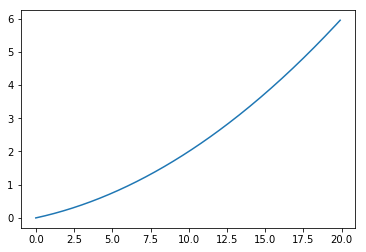

In [51]:
x = np.arange(0.0, 20.0, 0.1) #배열 생성
y = function_1(x)
plt.plot(x,y)
plt.show()

In [52]:
# x = 5, x=10 일때의 미분값 
numerical_diff(function_1, 5) # 실제값 0.2
numerical_diff(function_1, 10) # 실제값 0.3

0.1999999999990898

0.2999999999986347

#### 편미분 : 변수가 2개 이상인 경우 

In [53]:
# 편미분할 함수 구현
def function_2(x):
    return x[0]**2 + x[1]**2

![](img/028.jpg)

In [8]:
# x0=3 x1=4 일때 x0에 대한 편미분
def function_tmp1(x0):
    return x0*x0 + 4**2

numerical_diff(function_tmp1, 3)

6.00000000000378

In [9]:
# x0=3 x1=4 일때 x1에 대한 편미분
def function_tmp2(x1):
    return 3**2 + x1**2

numerical_diff(function_tmp2, 4)

7.999999999999119

### 기울기
#### 모든 변수에 대해 편미분을 동시에 계산하여 벡터로 정의 --> 기울기(Gradient)

In [10]:
# Gradient 구현
def numerical_gradient(f,x):
    h = 1e-4
    grad = np.zeros_like(x) # x와 같은 형상의 배열 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        x[idx] = tmp_val + h # f(x+h) 계산
        fxh1 = f(x)
        
        x[idx] = tmp_val - h # f(x-h) 계산
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad

In [57]:
#각 지점에서의 개별 기울기
numerical_gradient(function_2,np.array([3.,4.]))
numerical_gradient(function_2,np.array([0.0,2.0]))

array([6., 8.])

array([0., 4.])

#### 벡터로 표현 : 낮은곳으로 갈수록 기울기 감소
![](img/029.jpg)

### 경사하강법의 등장 

#### 안장점이나, 국소적인 최소값이 극솟값 등 벡터가 가리키는 곳이 최소값이 아닌경우도 있다!

1. 현 위치에서 기울어진 방향으로 일정 거리만큼 이동 
2. 이동한 위치에서 기울기를 구함
3. 1번 을 반복 

#### 경사하강법 수식 표현
##### eta 는 learing rate 를 의미
![](img/030.jpg)

In [58]:
#경사하강법 구현 
def gradient_descent(f,init_x, lr=0.01, step_num=100):
    x = init_x #초기 시작지점 
    
    for i in range(step_num):  #정해놓은 스템 수 만큼 경사하강을 한다.
        grad = numerical_gradient(f,x)
        x -= lr * grad
    return x

In [59]:
# grad descent 로 최소값 구하기
gradient_descent(function_2, np.array([-3.,4.]) , lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

![](img/031.jpg)

In [25]:
gradient_descent(function_2, np.array([-3.,4.]) , lr=10, step_num=100) 
# learning rate 가 너무 큰 경우

array([-2.58983747e+13, -1.29524862e+12])

In [26]:
gradient_descent(function_2, np.array([-3.,4.]) , lr=1e-10, step_num=100)
# learning rate 가 너무 작은 경우

array([-2.99999994,  3.99999992])

### 신경망에서의 기울기 
#### 기울기 -> 가중치 매개변수에 대한 손실 함수의 기울기 
#### 형상 2*3 가중치 W 손실함수 L 인 경우      경사는 dL/dW 로 표현
![](img/032.jpg)


In [11]:
#기울기 구하는 코드 
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화된 2*3 행렬 생성
    
    def predict(self, x):
        return np.dot(x, self.W) #행렬곱
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y,t)
        return loss

#### 테스트

In [28]:

net = simpleNet()
print(net.W)

[[ 0.01235625  1.01839205  0.6570892 ]
 [-0.21602419  0.66116951  0.38981433]]


In [29]:
x = np.array([.6,.9])
p = net.predict(x)
p

array([-0.18700802,  1.20608779,  0.74508642])

In [30]:
np.argmax(p) # 최대값 인덱스

1

In [31]:
t= np.array([1,0,0]) # 정답 레이블
net.loss(x,t)

2.023812010322066

#### 기울기 구하기 
#### numerical gradient를 사용하여 구함 W는 더미

In [32]:
def f(W):
    return net.loss(x,t)

In [33]:
dW = numerical_gradient(f, net.W)
dW

array([[-0.52070922,  0.31932582,  0.2013834 ],
       [-0.78106383,  0.47898872,  0.30207511]])

##### 위의 출력 값은 W값의 변화에 손실 함수 값이 얼마나 변하는지를 보여줌
##### a라는 값이 나오면 w를 h만큼 증가시키면 
##### 손실함수는 a*h만큼 증가함 
##### a 값이 음수인 경우 w값이 증가하면 손실함수 값 감소  --> 손실함수를 줄이는 방향으로 W를 갱신해야함

In [34]:
f = lambda w: net.loss(x,t)
dW = numerical_gradient(f, net.W)
dW

array([[-0.52070922,  0.31932582,  0.2013834 ],
       [-0.78106383,  0.47898872,  0.30207511]])

### 학습 알고리즘 구현하기 
- 전제 : 신경망에는 적응 가능한 W,b 존재 --> W,b를 훈련데이터에 적응하도록 조정하는 과정을 '학습'이라 부름 
- 1단계 미니배치 : 훈련데이터를 무작위로 가져옴, 손실함수 값을 줄이는 것이 목표
- 2단계 기울기 산출 : 가중치 매개변수의 기울기를 구함 --> 손실함수 값을 줄이는 방향을 제시
- 3단계 매개변수 갱신 : 가중치 매개변수를 기울기 방향으로 조금씩 갱신
- 4단계 1-3 단계를 반복

데이터를 미니배치로 무작위 선정하는 것을 "확률적 경사하강법 (Stochastic gradient decent)" 라고 부르며 SGD로 불리며 함수로제공된다

### 2층 신경망 클래스 구현

In [14]:
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01 ):
        #가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.rand(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.rand(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) +b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) +b2
        y = softmax(a2)
        
        return y
    
    # 입력 x, 정답 라벨 t
    def loss(self, x, t):
        y= self.predict(x)
        return cross_entropy_error(y,t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y ==t)/ float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x,t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
        
        


![](img/033.jpg)

In [36]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params['W1'].shape
net.params['b1'].shape
net.params['W2'].shape
net.params['b2'].shape

(784, 100)

(100,)

(100, 10)

(10,)

In [117]:
x = np.random.rand(100,784) # 더미데이터 생성
y = net.predict(x)

In [118]:
t = np.random.rand(100,10) #정답레이블

grands = net.numerical_gradient(x,t) #기울기 계산


KeyboardInterrupt: 

In [ ]:
grands['W1'].shape
grands['b1'].shape
grands['W2'].shape
grands['b2'].shape

### 미니배치 학습 구현

In [62]:
from dataset.mnist import load_mnist
#from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

#하이퍼 파라메터 / 시간관계상 짧게 처리 
iters_num = 10 #반복횟수
train_size = x_train.shape[0]
batch_size = 100 #미니배치 크기
learning_rate = 1
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    #미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    #기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    
    #매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    #학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

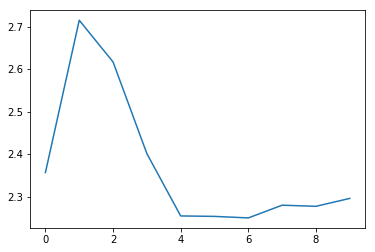

In [63]:
plt.plot(train_loss_list)
plt.rcParams["figure.figsize"] = (4,2)
plt.show()

![](img/034.jpg)

#### 시험 데이터로 평가

In [17]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

#하이퍼 파라메터 / 시간관계상 짧게 처리 
iters_num = 1000 #10000 에서 시간관계상 줄임
train_size = int(x_train.shape[0]/10) #60000에서 시간관계상 1/10으로 줄임
batch_size = 100
learning_rate = 0.5 # 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

train_loss_list = []
train_acc_list = []
test_acc_list= []

#1epoch 당 반복 횟수 
iter_per_epoch = max(train_size/batch_size,1)


In [ ]:
for i in range(iters_num):
    #미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    #기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    #grad = network.gradient(x_batch, t_batch)
    
    #매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    #학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1epoch 당 정확도 계산
    if i % iter_per_epoch ==0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

In [ ]:
plt.plot(train_acc_list)
plt.show()

In [ ]:
plt.plot(test_acc_list)
plt.show()

![](img/035.jpg)